# FBS(혈당)

### X변수(기본)
- sex : 1(남자), 2(여자)
- age : 20세 부터 5세 단위
- ht : 5cm단위
- wt : 5kg 단위
- waist : 허리둘레 cm
- bmi 
- absi : 체형지수 => 허리둘레 / (BMI * 2/3) * (ht * 1/2)
- smoking : 1(피우지 않음), 2(피웠다끊음), 3(피우고있음)
- alcohol : 0(마시지않음), 1(마심)

In [1]:
import pandas as pd
import numpy as np
import random

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 한글 지원
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf" 
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 상관계수
from scipy import stats

# model
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler

## 1. 데이터 불러오기

In [3]:
df = pd.read_csv('C:/Users/sja95/OneDrive/바탕 화면/dataset/건강검진2017.csv', encoding = 'euc-KR')

df.columns

Index(['기준년도', '가입자일련번호', '성별코드', '연령대코드(5세단위)', '시도코드', '신장(5Cm단위)',
       '체중(5Kg단위)', '허리둘레', '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '수축기혈압',
       '이완기혈압', '식전혈당(공복혈당)', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤',
       '혈색소', '요단백', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '흡연상태',
       '음주여부', '구강검진수검여부', '치아우식증유무', '결손치유무', '치아마모증유무', '제3대구치(사랑니)이상', '치석',
       '데이터공개일자'],
      dtype='object')

In [4]:
df = df[['성별코드','연령대코드(5세단위)','신장(5Cm단위)','체중(5Kg단위)','허리둘레','흡연상태','음주여부','식전혈당(공복혈당)']]
df.columns = ['sex','age','ht','wt','waist','smoking','alcohol','fbs']

## 2. 데이터 전처리

### 1) 결측값 제거

In [5]:
df = df.dropna(axis = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999062 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      999062 non-null  int64  
 1   age      999062 non-null  int64  
 2   ht       999062 non-null  int64  
 3   wt       999062 non-null  int64  
 4   waist    999062 non-null  float64
 5   smoking  999062 non-null  float64
 6   alcohol  999062 non-null  object 
 7   fbs      999062 non-null  float64
dtypes: float64(3), int64(4), object(1)
memory usage: 68.6+ MB


### 2) bmi column 생성

In [6]:
df['bmi'] = df['wt'] / ((df['ht']/100)**2)

### 3) absi columns 생성

- 허리둘레 / (BMI * 2/3) * (ht * 1/2)

In [7]:
df['absi'] = (df['waist']*0.393701) /((df['bmi']**0.6666) * ((df['ht']/100)**0.5))
df = df.round(decimals = 2)

df.head()

,sex,age,ht,wt,waist,smoking,alcohol,fbs,bmi,absi
0,1,8,170,75,90.0,1.0,Y,99.0,25.95,3.10
1,1,7,180,80,89.0,3.0,N,106.0,24.69,3.08
2,1,9,165,75,91.0,1.0,N,98.0,27.55,3.06
3,1,11,175,80,91.0,1.0,N,95.0,26.12,3.08
4,1,11,165,60,80.0,1.0,N,101.0,22.04,3.12


### 3) alcohol : str -> float형으로 변환

In [8]:
df.loc[(df.alcohol=='Y'),'alcohol'] = 1.0
df.loc[(df.alcohol=='N'), 'alcohol'] = 0.0

df['alcohol'] = df.alcohol.astype(float)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999062 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      999062 non-null  int64  
 1   age      999062 non-null  int64  
 2   ht       999062 non-null  int64  
 3   wt       999062 non-null  int64  
 4   waist    999062 non-null  float64
 5   smoking  999062 non-null  float64
 6   alcohol  999062 non-null  float64
 7   fbs      999062 non-null  float64
 8   bmi      999062 non-null  float64
 9   absi     999062 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 83.8 MB


#### (2) 이상값 제거

In [10]:
# bmi
#df.drop(df.loc[(df['bmi']>39.36)|(df['bmi']<8.07)].index, inplace = True)

# waist
df.drop(df.loc[(df['waist']>128.9)|(df['waist']<55.0)].index, inplace = True)

# absi
df.drop(df.loc[(df['absi']>3.94)|(df['absi']<2.12)].index, inplace = True)

# fbs
#df.drop(df.loc[(df['fbs']>200.0)|(df['fbs']<37.0)].index, inplace = True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998122 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      998122 non-null  int64  
 1   age      998122 non-null  int64  
 2   ht       998122 non-null  int64  
 3   wt       998122 non-null  int64  
 4   waist    998122 non-null  float64
 5   smoking  998122 non-null  float64
 6   alcohol  998122 non-null  float64
 7   fbs      998122 non-null  float64
 8   bmi      998122 non-null  float64
 9   absi     998122 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 83.8 MB


## 2. Scaling

- 표준화(Standardization)
- 정규화(Normalization)
- 로그변환(log) => target

### 1) 표준화 : df_s

In [16]:
scaler2 = StandardScaler()

x_bmi = scaler2.fit_transform(df[['bmi']])
x_waist = scaler2.fit_transform(df[['waist']])
x_absi = scaler2.fit_transform(df[['absi']])

df_s = df[['sex','age','wt','smoking','alcohol','fbs']]

df_s['bmi'] = x_bmi
df_s['waist'] = x_waist
df_s['absi'] = x_absi


print(df_s.info())
df_s.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 998122 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      998122 non-null  int64  
 1   age      998122 non-null  int64  
 2   wt       998122 non-null  int64  
 3   smoking  998122 non-null  float64
 4   alcohol  998122 non-null  float64
 5   fbs      998122 non-null  float64
 6   bmi      998122 non-null  float64
 7   waist    998122 non-null  float64
 8   absi     998122 non-null  float64
dtypes: float64(6), int64(3)
memory usage: 76.2 MB
None


,sex,age,wt,smoking,alcohol,fbs,bmi,waist,absi
0,1,8,75,1.0,1.0,99.0,0.578401,0.920789,0.339865
1,1,7,80,3.0,0.0,106.0,0.219741,0.816375,0.239229
2,1,9,75,1.0,0.0,98.0,1.033841,1.025202,0.138593
3,1,11,80,1.0,0.0,95.0,0.626791,1.025202,0.239229
4,1,11,60,1.0,0.0,101.0,-0.534581,-0.123345,0.440502


### 2) 정규화 : df_n

In [37]:
scaler1 = MinMaxScaler()

x_bmi = scaler1.fit_transform(df[['bmi']])
x_waist = scaler1.fit_transform(df[['waist']])
x_absi = scaler1.fit_transform(df[['absi']])

df_n = df[['sex','age','ht','wt','smoking','alcohol', 'fbs']]

df_n['bmi'] = x_bmi
df_n['waist'] = x_waist
df_n['absi'] = x_absi

print(df_n.info())
df_n.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 987176 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   sex      987176 non-null  int64  
 1   age      987176 non-null  int64  
 2   ht       987176 non-null  int64  
 3   wt       987176 non-null  int64  
 4   smoking  987176 non-null  float64
 5   alcohol  987176 non-null  float64
 6   fbs      987176 non-null  float64
 7   bmi      987176 non-null  float64
 8   waist    987176 non-null  float64
 9   absi     987176 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 82.8 MB
None


,sex,age,ht,wt,smoking,alcohol,fbs,bmi,waist,absi
0,1,8,170,75,1.0,1.0,99.0,0.504309,0.479452,0.538462
1,1,7,180,80,3.0,0.0,106.0,0.457100,0.465753,0.527473
2,1,9,165,75,1.0,0.0,98.0,0.564256,0.493151,0.516484
3,1,11,175,80,1.0,0.0,95.0,0.510678,0.493151,0.527473
4,1,11,165,60,1.0,0.0,101.0,0.357812,0.342466,0.549451


In [12]:
# fbs - 로그변환

df['fbs_log'] = np.log1p(df['fbs'])

df.head()

,sex,age,ht,wt,waist,smoking,alcohol,fbs,bmi,absi,fbs_log
0,1,8,170,75,90.0,1.0,1.0,99.0,25.95,3.10,4.605170
1,1,7,180,80,89.0,3.0,0.0,106.0,24.69,3.08,4.672829
2,1,9,165,75,91.0,1.0,0.0,98.0,27.55,3.06,4.595120
3,1,11,175,80,91.0,1.0,0.0,95.0,26.12,3.08,4.564348
4,1,11,165,60,80.0,1.0,0.0,101.0,22.04,3.12,4.624973


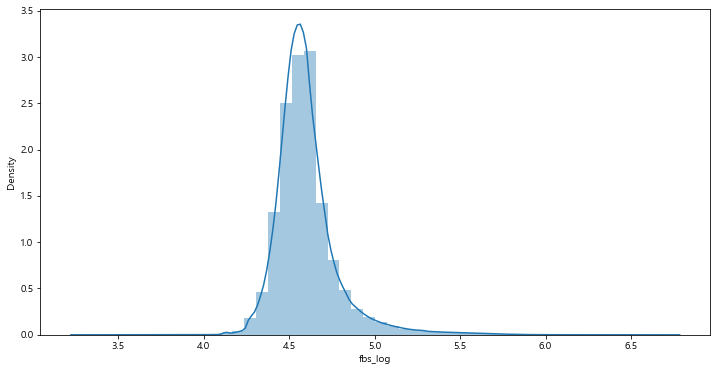

In [13]:
plt.figure(figsize = (12,6))
sns.distplot(df.fbs_log, hist = True, kde = True)
plt.show()

# 3. Modeling 

## 1-4) Linear Regression _ log변환

In [23]:
print(np.log1p(100))
print(np.expm1(np.log1p(100)))

4.61512051684126
100.00000000000003


In [15]:
## 1. split

X = df[['sex','age','ht','wt','bmi','absi','waist','smoking','alcohol']]
y = df['fbs_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)


In [16]:
X_test
y_test

261948    4.605170
703231    4.584967
602833    4.934474
910743    4.795791
214555    4.510860
            ...   
426417    4.430817
563438    4.564348
100507    4.276666
564470    4.564348
495145    4.382027
Name: fbs_log, Length: 299437, dtype: float64

In [17]:
X_test.reset_index(drop = True, inplace = True)
X_test

y_test.reset_index(drop = True, inplace = True)
y_test

0         4.605170
1         4.584967
2         4.934474
3         4.795791
4         4.510860
            ...   
299432    4.430817
299433    4.564348
299434    4.276666
299435    4.564348
299436    4.382027
Name: fbs_log, Length: 299437, dtype: float64

MAE :  12.66490124817248
rmse :  23.1740626113623


<AxesSubplot:>

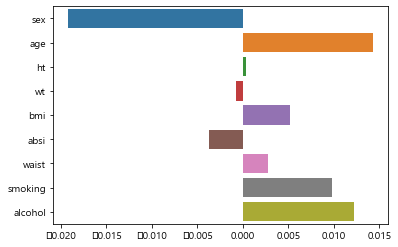

In [44]:
## 2. fit 

RA = LinearRegression()
RA.fit(X_train, y_train)

## 3. Predict

y_hat_log = RA.predict(X_test)


y_hat = np.expm1(y_hat_log)
y = np.expm1(y_test)

error = abs(y - y_hat)

print('MAE : ', np.mean(error))

## 4. Root MSE 

rmse = np.sqrt(mean_squared_error(np.expm1(y_test), y_hat))

print('rmse : ', rmse)


coef = pd.Series(RA.coef_, index = X_train.columns)
sns.barplot(x = coef.values, y = coef.index)

### Linear Regression - 원본

MAE :  13.109110176787553
rmse :  23.105223506030445


<AxesSubplot:>

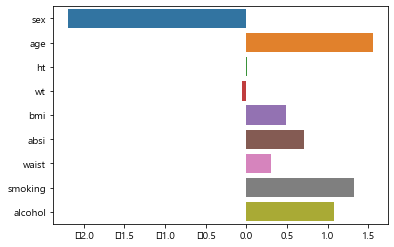

In [45]:
## 1. split

X = df[['sex','age','ht','wt','bmi','absi','waist','smoking','alcohol']]
y = df['fbs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)


## 2. fit 

RA = LinearRegression()
RA.fit(X_train, y_train)

## 3. Predict

y_hat= RA.predict(X_test)

error = abs(y_test - y_hat)

print('MAE : ', np.mean(error))

## 4. Root MSE 

rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse)


coef = pd.Series(RA.coef_, index = X_train.columns)
sns.barplot(x = coef.values, y = coef.index)

In [30]:
i = random.randint(0,len(X_test))

print(i)

x = X_test.loc[i]
print(x)

y = y_test.loc[i]

print(y)

137768
sex          1.00
age         13.00
ht         160.00
wt          70.00
bmi         27.34
absi         3.26
waist       95.00
smoking      1.00
alcohol      0.00
Name: 137768, dtype: float64
4.564348191467836


In [41]:
y_hat = RA.predict(pd.DataFrame(x).transpose())
print(y_hat[0])
print(np.expm1(0.12))

print('실제 y값 : ', np.expm1(y))
print('예측한 y값 : ', np.expm1(y_hat[0]))

4.681120714027658
0.12749685157937568
실제 y값 :  94.99999999999999
예측한 y값 :  106.89091970838516


## 2-1) ( Polynomial ) Linear Regression2차_이상치제거

In [59]:
## 1. split

X = df_o[['sex','age','bmi','ht','wt','waist','absi','smoking','alcohol']]
y = df_o['fbs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((699343, 9), (299719, 9), (699343,), (299719,))

In [60]:
## 2. polynomialFeatures(degree=2)

poly_train = PolynomialFeatures(degree=2).fit_transform(X_train)


## 3. Linear Regression 

PLR = LinearRegression()
PLR.fit(poly_train, y_train)

## 4. Predict

poly_test = PolynomialFeatures(degree=2).fit_transform(X_test)
y_hat = PLR.predict(poly_test)

## 5. RMSE

rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse)

rmse :  23.12436533548611


In [61]:
## 1. split

X = df[['sex','age','bmi','ht','wt','waist','absi','smoking','alcohol']]
y = df['fbs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((691023, 9), (296153, 9), (691023,), (296153,))

In [62]:
## 2. polynomialFeatures(degree=2)

poly_train = PolynomialFeatures(degree=2).fit_transform(X_train)


## 3. Linear Regression 

PLR = LinearRegression()
PLR.fit(poly_train, y_train)

## 4. Predict

poly_test = PolynomialFeatures(degree=2).fit_transform(X_test)
y_hat = PLR.predict(poly_test)

## 5. RMSE

rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse)

rmse :  16.44208464068787


## 2-2) ( Polynomial ) Linear Regression3차_이상치제거

In [63]:
## 1. split

X = df_o[['sex','age','bmi','ht','wt','waist','absi','smoking','alcohol']]
y = df_o['fbs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((699343, 9), (299719, 9), (699343,), (299719,))

In [249]:
## 2. polynomialFeatures(degree=3)

poly_train = PolynomialFeatures(degree=3).fit_transform(X_train)


## 3. Linear Regression 

PLR = LinearRegression()
PLR.fit(poly_train, y_train)

## 4. Predict

poly_test = PolynomialFeatures(degree=3).fit_transform(X_test)
y_hat = PLR.predict(poly_test)

## 5. RMSE

rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse)


rmse :  9.206657849893517


In [64]:
## 1. split

X = df[['sex','age','bmi','ht','wt','waist','absi','smoking','alcohol']]
y = df['fbs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((691023, 9), (296153, 9), (691023,), (296153,))

In [65]:
## 2. polynomialFeatures(degree=3)

poly_train = PolynomialFeatures(degree=3).fit_transform(X_train)


## 3. Linear Regression 

PLR = LinearRegression()
PLR.fit(poly_train, y_train)

## 4. Predict

poly_test = PolynomialFeatures(degree=3).fit_transform(X_test)
y_hat = PLR.predict(poly_test)

## 5. RMSE

rmse = np.sqrt(mean_squared_error(y_test, y_hat))

print('rmse : ', rmse)


rmse :  16.414643732878176


### 4차 다항회귀분석을 수행했을 때는 오히려 rmse가 15로 증가
### - Overfitting으로 인해 오히려 성능저하로 판단. 

### 정규화와 표준화는 polynomial linear regression 에서는 차이가 없음(rmse값 소수 4째자리에서 차이발생)

## 3-1) 규제선형모델 Ridge Regression_원본

- 표준화, 정규화 등 scaling 처리한 데이터와 원본 데이터의 결과 성능이 차이가 없음

In [66]:
## 1. split

X = df[['sex','age','ht','wt','bmi','absi','waist','smoking','alcohol']]
y = df['fbs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((691023, 9), (296153, 9), (691023,), (296153,))

In [67]:
## 2. model define

alphas = [0, 0.1, 1, 10, 100]

for alpha in alphas :
    
    ridge = Ridge(alpha = alpha)
    ridge.fit(X_train, y_train)
    y_hat = ridge.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_hat))
    
    print('===== alpha = ', alpha, ' =====')
    print('rmse : ', rmse)

===== alpha =  0  =====
rmse :  16.486398624550116
===== alpha =  0.1  =====
rmse :  16.486398663723058
===== alpha =  1  =====
rmse :  16.486399016437392
===== alpha =  10  =====
rmse :  16.486402556718286
===== alpha =  100  =====
rmse :  16.48643759504328


## 3-2) Lasso Regression_원본

- Ridge와 마찬가지로 x를 scaling한 데이터와 모델 성능에 차이가 없음

In [68]:
## 1. split

X = df[['sex','age','ht','wt','bmi','absi','waist','smoking','alcohol']]
y = df['fbs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((691023, 9), (296153, 9), (691023,), (296153,))

In [70]:
## 2. model define

alphas = [0, 0.07, 1, 10, 100]

for alpha in alphas :
    
    lasso = Lasso(alpha = alpha)
    lasso.fit(X_train, y_train)
    y_hat = lasso.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_hat))
    
    print('===== alpha = ', alpha, ' =====')
    print('rmse : ', rmse)

===== alpha =  0  =====
rmse :  16.48640420687979
===== alpha =  0.07  =====
rmse :  16.489393555742044
===== alpha =  1  =====
rmse :  16.540436591883445
===== alpha =  10  =====
rmse :  16.924272260149856
===== alpha =  100  =====
rmse :  17.52064639005803


## 3-3) ElasticNet Regression _원본

In [71]:
## 1. split

X = df[['sex','age','ht','wt','bmi','absi','waist','smoking','alcohol']]
y = df['fbs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2045)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((691023, 9), (296153, 9), (691023,), (296153,))

In [73]:
## 2. model define

alphas = [0,0.07, 0.1, 0.3, 0.5, 1]

for alpha in alphas :
    
    elastic = ElasticNet(alpha = alpha, l1_ratio=0.7)
    elastic.fit(X_train, y_train)
    y_hat = elastic.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_hat))
    
    print('===== alpha = ', alpha, ' =====')
    print('rmse : ', rmse)

===== alpha =  0  =====
rmse :  16.48640420687979
===== alpha =  0.07  =====
rmse :  16.489603087685015
===== alpha =  0.1  =====
rmse :  16.49144395554293
===== alpha =  0.3  =====
rmse :  16.508944699252194
===== alpha =  0.5  =====
rmse :  16.52317572027042
===== alpha =  1  =====
rmse :  16.54120156143516


## 모델성능 : 3차 Linear Regression > 2차 Linear Regression > LinearRegression = Ridge = Lasso = ElasticNet

- Linear Regression 성능은 크게 개선되는 모델 없이 대략 rmse가 9.1~9.2을 보임. 

- 과적합 우려가 있어서 규제선형모델(ridge, lasso, elasticNet)을 정의해보았는데 오히려 규제를 할수록 성능이 아주조금씩 저하됨

- linear regression에서는 과적합 문제는 이슈가 되지 않는다고 판단. 